In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

### Data import and preparation

In [2]:
# read in data
tracks = pd.read_csv('spotify_dat.csv', index_col = 0)

In [4]:
# remove columns we won't be using for this recommendation algorithm
tracks.drop(['recently_played', 'saved_tracks', 'top_tracks', 'Rating01', 'Rating0-5','AddPlylst01'], axis = 1, inplace = True)

In [5]:
# standardize data, because clustering is sensitive to measurements not on the same scale
scale = StandardScaler()

# just a reference list of which features are categorical and which are numeric
categorical_features = ['explicit', 'mode', 'album_big_label', 'album_medium_label', 'genre_alternative metal/rock',
                       'genre_background', 'genre_baroque classic', 'genre_classical', 'genre_country', 'genre_hip hop',
                       'genre_house', 'genre_indie', 'genre_mexican', 'genre_pop', 'genre_rap', 'genre_rock',
                       'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'overall_key_1',
                       'overall_key_2', 'overall_key_3', 'overall_key_4', 'overall_key_5', 'overall_key_6', 'overall_key_7',
                       'overall_key_8', 'overall_key_9', 'overall_key_10', 'overall_key_11']
numerical_features = ['album_popularity', 'artist_popularity', 'artist_followers', 'popularity', 'track_number', 'acousticness',
                     'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
                     'num_of_sections', 'num_of_keys', 'num_of_modes', 'num_of_time_signatures', 'duration_minutes',
                     'section_durations_variance', 'section_durations_min', 'section_durations_max', 'section_loudnesses_variance',
                     'section_loudnesses_min', 'section_durations_max', 'section_tempos_variance', 'section_tempos_min', 'section_tempos_max']

# we only standardize numerical features
scaled_tracks = pd.DataFrame(scale.fit_transform(tracks[numerical_features]))
scaled_tracks.columns = tracks[numerical_features].columns.values
tracks[numerical_features] = scaled_tracks
tracks.reset_index(drop = True, inplace = True)

In [6]:
# with so many features, let's also prepare a version of our dataset with pca components, to help reduce dimensions
# this might be useful given how some clustering methods perform poorly in high dimensions

# remove identifying features
identifying_features = ['name', 'uri', 'album_uri', 'album_name', 'artist_uri', 'artist_name']
tracks_test = tracks.drop(identifying_features + ['df_label'], axis = 1)
# fit PCA
tracks_pca = PCA().fit(tracks_test)

# how many components do we need to capture most of the variance?
np.cumsum(tracks_pca.explained_variance_ratio_)

array([0.67334052, 0.87074056, 0.88606055, 0.89979591, 0.9099358 ,
       0.91915812, 0.92776766, 0.93519078, 0.94183845, 0.94782988,
       0.95295346, 0.95755099, 0.96202133, 0.96607318, 0.96972404,
       0.97292927, 0.97587108, 0.9782362 , 0.98043277, 0.98243644,
       0.98437131, 0.98617269, 0.9878945 , 0.98897026, 0.98979631,
       0.9905452 , 0.99124027, 0.99180531, 0.99231077, 0.99279679,
       0.99326929, 0.99373039, 0.99418871, 0.99462266, 0.99502776,
       0.99540968, 0.99578886, 0.99614746, 0.99650197, 0.9968548 ,
       0.99719066, 0.99750141, 0.99779616, 0.99807526, 0.99834599,
       0.99856077, 0.99875312, 0.99893413, 0.99910201, 0.99925945,
       0.99940391, 0.99951935, 0.9996172 , 0.99971332, 0.99978788,
       0.99985273, 0.99991634, 0.9999612 , 0.99999864, 1.        ])

The first 2 components capture the majority of the variation among predictors (~87%).  
Let's keep only the first 5 components.

In [7]:
# save dataset version with pca dimension reduction applied
tracks_pca = pd.DataFrame(PCA(n_components = 5).fit_transform(tracks_test))
tracks_pca.columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']

In [8]:
# extract tracks for user4
user4_tracks = tracks[tracks['df_label'] == 'user4'].drop('df_label', axis = 1).reset_index(drop = True)

In [9]:
# extracting user tracks for dimension-reduced version of data
tracks_pca = pd.concat([tracks_pca, tracks['df_label']], axis = 1)

In [10]:
user4_pca_tracks = tracks_pca[tracks_pca['df_label'] == 'user4'].drop('df_label', axis = 1).reset_index(drop = True)

tracks_pca.drop('df_label', axis = 1, inplace = True)

In [11]:
# we also need to reattach df_label column and subset the global data only
tracks_test['df_label'] = tracks['df_label']
tracks_pca['df_label'] = tracks['df_label']

# and create a reference dataset
tracks_reference = tracks[tracks['df_label'] == 'global'].reset_index(drop = True)
tracks_test = tracks_test[tracks_test['df_label'] == 'global'].drop(['df_label'], axis = 1).reset_index(drop = True)
tracks_pca = tracks_pca[tracks_pca['df_label'] == 'global'].drop(['df_label'], axis = 1).reset_index(drop = True)

In [12]:
# prepare data for clustering and computations by removing columns that contain track identifying information and meta data
# i.e. we only want numerical columns that can be used for computations
user4_train = user4_tracks.drop(identifying_features, axis = 1).reset_index(drop = True)

### Clustering a user's profile data

Our goal with clustering is to capture what are the defining characteristics of the songs a user listens to. The fit will then be used to recommend new songs that the user might enjoy. The benefits here are that the clustering is unique to each user, which could lead to better recommendations that are informed by the nuances of a user's listening history.

However, clustering is usually quite manual; it requires visualizing and looking at different kinds of plots to determine the best parameters for each algorithm and domain knowledge and judgment to determine appropriate clusters. If we want to scale our clustering to be used in a recommender system, it's not feasible to perform clustering for each user individually. So we'd like to automate it.  

To that end, in order to pick the best clustering algorithm and the best parameters for said algorithm for each user, we'll be using the average silhouette coefficient, which has a range of [-1, +1]. A score near +1 indicates clusters are generally far away from neighboring clusters, and are therefore well defined, whereas a score near -1 indicates incorrect clustering and overlap; and a score near 0 indicates the clusters are close to the decision boundaries.  


We're interested in finding dense and well-separated aspects of a user's listening history; therefore, the silhouette coefficient is a good match. It also allows us to automate the clustering the process without too much qualitative human input.

In [13]:
def cluster_user_profile(dat, pca_dat = 'empty', visualize = False, results_table = False):
    """
    Applies kmeans clustering to user data and pca version of user data (if supplied).
    Returns best kmeans model object, and dataframe with labels.
    Best kmeans object determined by silhouette coefficient score.
    Prints whether this was obtained with dat or pca_dat. 
    If visualize is set to True, then a TSNE 2d plot is displayed with the kmeans model. 
    If results_table is True, function returns dataframe of results table as well.
    """
    if type(pca_dat) != str:
        dfs = [(dat, 'regular'), (pca_dat,'pca')]
    else:
        dfs = [(dat,'regular')]
    
    # initialize dict to store results of different clustering
    results = {'data':[], 'silhouette_coeff':[], 'n_clusters':[]}
    
    # values of n_clusters param we will try
    param_n_clusters = [3, 4, 5, 6]
    
    # try out different kmeans models
    for df in dfs:
        for num in param_n_clusters:
            km = KMeans(n_clusters = num).fit(df[0])
            score = silhouette_score(df[0], km.labels_)
            results['data'] = results['data'] + [df[1]]
            results['silhouette_coeff'] = results['silhouette_coeff'] + [score]
            results['n_clusters'] = results['n_clusters'] + [num]
    
    # put results in dataframe
    results = pd.DataFrame(results).sort_values(by = 'silhouette_coeff', ascending = False)
    results.reset_index(drop = True, inplace = True)
    # parameterize the best model based on results
    best_n_clusters = int(results['n_clusters'][0])
    best_data = str(results['data'][0])
    best_kmeans = KMeans(n_clusters = best_n_clusters)
    # print which dataset was used
    print('The best silhouette coefficient score of', results['silhouette_coeff'][0], 'was obtained on', best_data, 'data, with', best_n_clusters, 'clusters.')
    
    # visualize if specified
    if visualize:
        if best_data == 'regular':
            visual_dat = dfs[0][0]
        else:
            visual_dat = dfs[1][0]
        visual = TSNE(perplexity = 30, learning_rate = 300).fit_transform(visual_dat)
        
        # fit the best kmeans model to get the labels
        km = best_kmeans.fit(visual_dat)
        plt.scatter(visual[:,0], visual[:,1], c = km.labels_)
    
    # return
    if best_data == 'regular':
        return_dat = dfs[0][0]
        return_dat['cluster_label'] = best_kmeans.fit(return_dat).labels_
    else:
        return_dat = dfs[1][0]
        return_dat['cluster_label'] = best_kmeans.fit(return_dat).labels_
    if results_table:
        return (return_dat, best_kmeans, results)
    else:
        return (return_dat, best_kmeans)

The best silhouette coefficient score of 0.40014465136714367 was obtained on pca data, with 4 clusters.


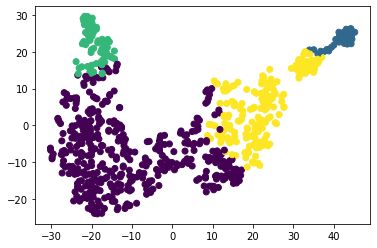

In [14]:
# apply function to cluster user4 data
user4_clustered, best_kmeans, results = cluster_user_profile(user4_train, user4_pca_tracks, results_table = True, visualize = True)

### Produce recommendations

In [20]:
numerical_features = ['album_popularity', 'artist_popularity', 'artist_followers', 'popularity', 'track_number', 'acousticness',
                     'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
                     'num_of_sections', 'num_of_keys', 'num_of_modes', 'num_of_time_signatures', 'duration_minutes',
                     'section_durations_variance', 'section_durations_min', 'section_loudnesses_variance',
                     'section_loudnesses_min', 'section_durations_max', 'section_tempos_variance', 'section_tempos_min', 'section_tempos_max']

In [21]:
def produce_playlists(global_data = tracks_pca, model = best_kmeans):
    """
    Produces dance, chill, and discover unpopular music playlists, each with 10 songs.
    Recommendations determined by cosine similarity with user cluster centroids. 
    """
    cluster_centers = model.cluster_centers_
    n_clusters = len(cluster_centers)

    cluster_names = []
    count = 0
    for i in range(n_clusters):
        count += 1
        cluster_names += ['cluster' + str(count)]
    
    # compute cosine similarity matrix
    similarity_df = pd.DataFrame(cosine_similarity(np.array(global_data), cluster_centers))
    similarity_df.columns = cluster_names
    similarity_df.reset_index(drop = True, inplace = True)


    # add identifying features
    similarity_df[identifying_features] = tracks_reference[identifying_features]
    similarity_df.reset_index(drop = True, inplace = True)

    # add other features
    similarity_df[numerical_features] = tracks_reference[numerical_features]

    # how many songs out of 10 to recommend corresponding to each cluster 
    num_for_cluster = []
    if 10 % n_clusters == 0:
        for i in range(n_clusters):
            num_for_cluster += [int(10/n_clusters)]
    elif 10 % n_clusters != 0:
        for i in range(n_clusters):
            num_for_cluster += [int(10/n_clusters)]
        num_for_cluster[0] += (int(10 % n_clusters)+1)
   
    # dance playlist
    for i in range(n_clusters):
        if i == 0:
            to_extract = similarity_df[similarity_df['danceability'] > 0.7].sort_values(by = cluster_names[i], ascending = False).reset_index(drop = True)
            dance_playlist = to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:]
        to_extract = similarity_df[similarity_df['danceability'] > 0.7].sort_values(by = cluster_names[i], ascending = False)
        to_extract.reset_index(drop = True, inplace = True)
        dance_playlist = dance_playlist.append(to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:], ignore_index = True)
        dance_playlist = dance_playlist.drop_duplicates(subset = ["uri"])
        dance_playlist = dance_playlist.reset_index(drop=True)
        
    # chill playlist
    for i in range(n_clusters):
        if i == 0:
            to_extract = similarity_df[(similarity_df['tempo'] < 95) & (similarity_df['valence'] > 0.5)].sort_values(by = cluster_names[i], ascending = False)
            to_extract.reset_index(inplace = True, drop = True)
            chill_playlist = to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:]
        to_extract = similarity_df[(similarity_df['tempo'] < 95) & (similarity_df['valence'] > 0.5)].sort_values(by = cluster_names[i], ascending = False)
        to_extract.reset_index(drop = True, inplace = True)
        chill_playlist = chill_playlist.append(to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:], ignore_index = True)
        chill_playlist = chill_playlist.drop_duplicates(subset = ["uri"])
        chill_playlist = chill_playlist.reset_index(drop=True)
        
    # discover playlist
    for i in range(n_clusters):
        if i == 0:
            to_extract = similarity_df[(similarity_df['popularity'] < 60) & (similarity_df['artist_popularity'] < 80)].sort_values(by = cluster_names[i], ascending = False)
            to_extract.reset_index(inplace = True, drop = True)
            discover_playlist = to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:]
        to_extract = similarity_df[(similarity_df['popularity'] < 60) & (similarity_df['artist_popularity'] < 80)].sort_values(by = cluster_names[i], ascending = False)
        to_extract.reset_index(inplace = True, drop = True)
        discover_playlist = discover_playlist.append(to_extract[identifying_features + cluster_names].iloc[0:num_for_cluster[i],:], ignore_index = True)
        discover_playlist = discover_playlist.drop_duplicates(subset = ["uri"])
        discover_playlist = discover_playlist.reset_index(drop=True)
    
    return(dance_playlist, chill_playlist, discover_playlist)

In [22]:
# apply function to produce dance, chill, and discover playists
dance_playlist, chill_playlist, discover_playlist = produce_playlists()

In [24]:
# here's what the discover playlist looks like
discover_playlist

,name,uri,album_uri,album_name,artist_uri,artist_name,cluster1,cluster2,cluster3,cluster4
0,Hurry Back Baby,spotify:track:7msAfxlpbBIvbDLjdAWbzE,spotify:album:2kDLX1hiHZXEpEoOgmho2P,Weather,spotify:artist:7A9yZMTrFZcgEWAX2kBfK6,Huey Lewis & The News,0.998524,-0.895879,-0.018946,-0.640432
1,In and Out,spotify:track:3xraZ1L6Ylv353uTG66FSf,spotify:album:1A5Y5lbRxBNj2ri1XclTsQ,No Hooks,spotify:artist:0Cu32uCaqDJYQADOev92Et,Lud Foe,0.997121,-0.870635,-0.050641,-0.598108
2,Family and Loyalty,spotify:track:5tHf0v419Ia09AS9sEK6iF,spotify:album:0lUDIeE7KurGUVHrlmQTEN,Family and Loyalty,spotify:artist:5cMgGlA1xGyeAB2ctYlRdZ,Gang Starr,0.996699,-0.845181,-0.100535,-0.554738
3,So Good,spotify:track:0xjpgDNFyekbjessCBaaBq,spotify:album:3yuV4GeplvzBIiYGhQp2nd,Friends,spotify:artist:5FxD8fkQZ6KcsSYupDVoSO,Omar Apollo,0.996604,-0.907996,0.016607,-0.660728
4,IDKW (with Shenseea & Swae Lee feat. Young Thug),spotify:track:1wCxD13p8InyU5BQzNVh9O,spotify:album:4BU1vWNke8dvJoVgAosZbp,IDKW (with Shenseea & Swae Lee feat. Young Thug),spotify:artist:1fctva4kpRbg2k3v7kwRuS,Rvssian,0.996496,-0.853365,-0.106630,-0.576202
5,Fooled Around And Fell In Love,spotify:track:2hE5Lm5XOHR4t3xlhIFauP,spotify:album:2z2y977JvwU1rbnVO97RmY,Struttin' My Stuff,spotify:artist:2G1yVp387GlUf9yvLk6V11,Elvin Bishop,-0.885337,0.999828,-0.378378,0.901266
6,In A Sentimental Mood,spotify:track:0E8q2Fx2XuzXCO2NSAppkR,spotify:album:1OvmilWKtrabJGEpPRlgK5,Duke Ellington & John Coltrane,spotify:artist:4F7Q5NV6h5TSwCainz8S5A,Duke Ellington,-0.888408,0.999828,-0.369231,0.898536
7,"Piano Sonata No. 5 in C Minor, Op. 10 No. 1 ""L...",spotify:track:1TH9K3tXn8KI5Y0oeI43xg,spotify:album:6YB02sXZI4Hk0JKKZr2vue,"Beethoven: Complete Piano Sonatas, Vol. 2",spotify:artist:2wOqMjp9TyABvtHdOSOTUS,Ludwig van Beethoven,0.002397,-0.412187,0.999246,-0.602438
8,"Sonata No. 10 in G Major, Op. 14 No. 2: II. An...",spotify:track:47r0Nw0B9NqUUGjCjgVSzG,spotify:album:3YUXYC3J1hfqp5rQ83Ufd0,Beethoven: 32 Sonatas,spotify:artist:2wOqMjp9TyABvtHdOSOTUS,Ludwig van Beethoven,-0.064769,-0.355055,0.999026,-0.566826
9,This Is Why I'm Hot,spotify:track:0AA6zq5ArZ1sSH7VIMi4NK,spotify:album:42c0PgLPx6qRCZCzB8d7Pk,Music Is My Savior,spotify:artist:76RrKpsvOmSKG8CIjROdSG,MiMS,-0.660063,0.933241,-0.596653,0.991880


In [25]:
# save each playlist to file
dance_playlist.to_csv('dance_playlist_clustrec.csv', index = False)
chill_playlist.to_csv('chill_playlist_clustrec.csv', index = False)
discover_playlist.to_csv('discover_playlist_clustrec.csv', index = False)